In [1]:
import numpy as np
import pandas as pd

%matplotlib inline
import matplotlib.pyplot as plt
plt.style.use('ggplot')

from pandas.plotting import scatter_matrix
from sklearn.linear_model import LinearRegression, LogisticRegression
from sklearn.preprocessing import StandardScaler
from sklearn.feature_selection import SelectKBest, chi2
from sklearn.pipeline import Pipeline, FeatureUnion

In [2]:
df2018 = pd.read_csv('data/nmhss2018.csv')
df2018.columns = map(str.lower, df2018.columns)

In [3]:
sli2018 = df2018.head(1000)
sli2018 = sli2018.filter(regex=("ip.*"))

basic_demog = ['ipsextotm','ipsextotf','ipagetot017','ipagetot1864','ipagetot65']
ip2018 = df2018[basic_demog]


In [4]:
colors=['red','green']

In [6]:
# Possible features to look at more:
# FUNDSMHA: Accepts state mental health agency funds as source of payment for mental health treatment services
# FUNDSTATEWELFARE: Accepts state welfare or child and family services agency funds as source of payment for treatment 
# FUNDSTATEJUV: Accepts state corrections/juvenile justice agency funds as source of payment for mental health treatment services (Q.A24)
# FUNDOTHSTATE: Accepts other state government funds as source of payment for mental health treatment services

In [7]:
val_map = {0: 0, 1: 5.5, 2: 15.5, 3: 25.5, 4: 35.5, 5: 45.5, 6: 63, 7: 88, 8: 175.5, 9: 375.5, 10: 750.5, 11: 1250.5,
           12: 1500, -1: None, -2: None}

In [8]:
patient_est = ip2018.replace(val_map)

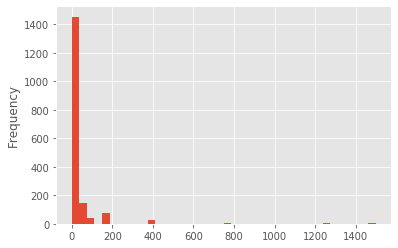

In [9]:
patient_est['ipsextotm'].plot.hist(bins=40)

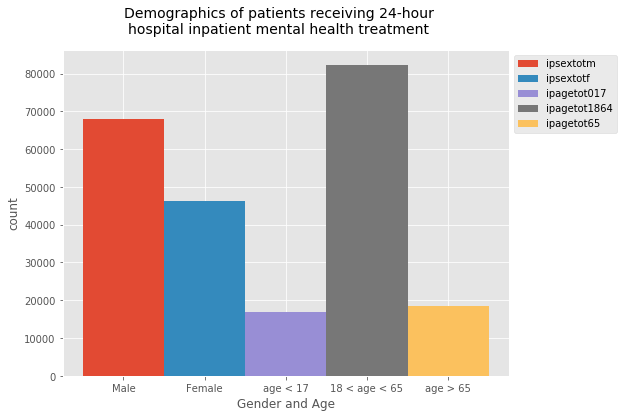

In [10]:
basic_demog = ['ipsextotm','ipsextotf','ipagetot017','ipagetot1864','ipagetot65']
ind = np.arange(len(basic_demog))
fig, ax = plt.subplots(figsize=(8, 6))

width = 0.2
for idx, demo in enumerate(basic_demog):
    ax.bar(idx*width, patient_est[patient_est[demo] > 0][demo].sum(), 
           width, label=demo)
    
plt.suptitle('Demographics of patients receiving 24-hour\nhospital inpatient mental health treatment', fontsize=14)
plt.ylabel('count')
plt.xlabel('Gender and Age')
plt.xticks(ind/5, ['Male', 'Female', 'age < 17', '18 < age < 65', 'age > 65'])
plt.legend(bbox_to_anchor=(1, 1), loc='upper left')
